In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt

In [1]:
# Goals of notebook: Generate A matrices with varying polar decomposition --> Plot the trajectories --> Calculate the LQG cost

In [49]:
def genA(theta, epsilon, delta):

    U = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    P = np.diag([1 - epsilon - delta, 1 - epsilon + delta]) 

    A = U @ P

    # Caley transformation to a continuous time dynamics matrix
    Ac = -1*(np.eye(2) - A) @ np.linalg.inv(np.eye(2) + A)

    return A, Ac   


In [55]:
A, Ac = genA(np.pi/4, 0.1, 0.3)

In [56]:
np.abs(np.linalg.eigvals(A))

array([0.84852814, 0.84852814])

In [57]:
np.linalg.eigvals(Ac)

array([-0.09355812+0.37506687j, -0.09355812-0.37506687j])

In [20]:
def LQG_score(A):
    P = scipy.linalg.solve_continuous_are(A, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))
    Q = scipy.linalg.solve_continuous_are(A.T, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))

    return np.trace(P @ Q)

In [30]:
A, Ac = genA(theta[3], 0.1, 0.1)

In [33]:
np.real(np.linalg.eigvals(Ac))

array([0.05579422, 0.05579422])

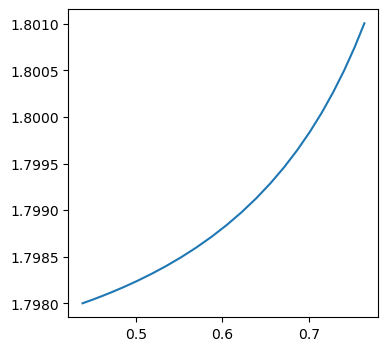

In [60]:
# Plot the spectrum of Ac as theta varies for a few value sof delta
theta = np.linspace(0, np.pi/3, 25)
delta = np.linspace(0, 0.2, 25)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

iml = np.zeros((theta.size, len(delta)))
ssnorm = np.zeros((theta.size, len(delta)))
lqgscore = np.zeros((theta.size, len(delta)))
pcascore = np.zeros((theta.size, len(delta)))

for i in range(theta.size):
    for j in range(len(delta)):
        A, Ac = genA(theta[i], 0.1, delta[j])
        # try:
        #     assert(np.max(np.real(np.linalg.eigvals(Ac))) < 0)
        # except:
        #     print(delta[j])
        iml[i, j] = np.imag(np.linalg.eigvals(Ac)[0])
        ssnorm[i, j] = np.linalg.norm(Ac - 0.5 * (Ac - Ac.T))/np.linalg.norm(Ac)
        lqgscore[i, j] = LQG_score(Ac)
        pcascore[i, j] = np.linalg.slogdet(scipy.linalg.solve_continuous_lyapunov(Ac, np.eye(Ac.shape[0])))[1]

In [76]:
import matplotlib.patches as mpatches

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax2 = ax.twinx()

ax.plot(ssnorm[5, :], lqgscore[5, 0] - lqgscore[5, :], color='r', linewidth=3, alpha=0.5)   
ax2.plot(ssnorm[5, :], pcascore[5, :] - pcascore[5, 0], color='k', linewidth=3, alpha=0.5)
red_patch = mpatches.Patch(color='red', label='FBC', alpha=0.5)
black_patch = mpatches.Patch(color='black', label='FFC', alpha=0.5)
ax.legend(handles = [red_patch, black_patch], loc = 'center left')
ax.set_xticks([])
ax.set_ylabel('Feedback Controllability', color='red', fontsize=14)
ax2.set_ylabel('Feedforward Controllability', fontsize=14)
ax.set_yticks([])
ax2.set_yticks([])
ax.set_xlabel(r'$||A - A_{ss}||/||A||$' + ' (a.u.)', fontsize=14)
fig.savefig('rotational_dependence.pdf', bbox_inches='tight', pad_inches=0)
